In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn.functional as F

In [3]:
words = open('names.txt', 'r').read().split('\n')
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
charset = sorted(list(set(''.join(words))))
charset

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [5]:
stoi = {s:i+1 for i, s in enumerate(charset)}
stoi['.'] = 0

In [6]:
itos = {i:s for s, i in stoi.items()}

In [7]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(89)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182530, 3]) torch.Size([182530])
torch.Size([22783, 3]) torch.Size([22783])
torch.Size([22833, 3]) torch.Size([22833])


In [8]:
n_embd = 10
n_hidden = 200
vocab_size = 27

g = torch.Generator().manual_seed(2525) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]

In [9]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [10]:
for p in parameters:
    p.requires_grad = True

In [11]:
lri = []
lossi = []
steps = []

In [12]:
max_steps = 200000
batch_size = 32

for i in range(max_steps):

    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    print(loss.item())  

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = -0.01 if i < 100000 else -0.01
    for p in parameters:
        p.data += lr * p.grad

    lri.append(lr)
    lossi.append(loss.log10().item())
    steps.append(i)
   

29.634279251098633
26.695878982543945
24.51122283935547
24.610855102539062
25.03080177307129
19.61326026916504
26.675413131713867
25.049083709716797
27.438106536865234
22.194416046142578
24.40261459350586
28.539291381835938
24.938858032226562
22.24599838256836
25.117517471313477
24.023448944091797
27.61249542236328
23.35545539855957
21.53777313232422
21.981487274169922
22.18931770324707
22.353670120239258
26.376256942749023
20.429866790771484
26.124513626098633
22.547809600830078
24.257938385009766
21.553058624267578
21.183107376098633
20.29972267150879
23.25649642944336
22.093154907226562
23.233739852905273
17.168167114257812
23.132844924926758
22.30754280090332
19.12485122680664
20.483810424804688
19.200231552124023
21.316022872924805
18.657615661621094
16.00139045715332
24.391185760498047
19.78937530517578
21.173730850219727
18.854053497314453
24.87871551513672
23.758081436157227
24.297672271728516
16.844831466674805
22.40241241455078
21.256107330322266
21.82947540283203
20.27486419

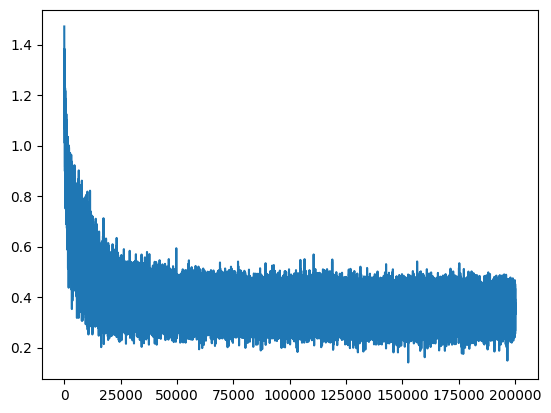

In [13]:
plt.plot(steps, lossi)

In [14]:
@torch.no_grad()
def split_loss(split):
    x, y = {
    'train': (Xtr, Ytr),
    'val' : (Xdev, Ydev),
    'test' : (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.4500980377197266
val 2.4500980377197266


In [15]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2796, grad_fn=<NllLossBackward0>)

In [16]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2956, grad_fn=<NllLossBackward0>)

In [17]:
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.2886, grad_fn=<NllLossBackward0>)

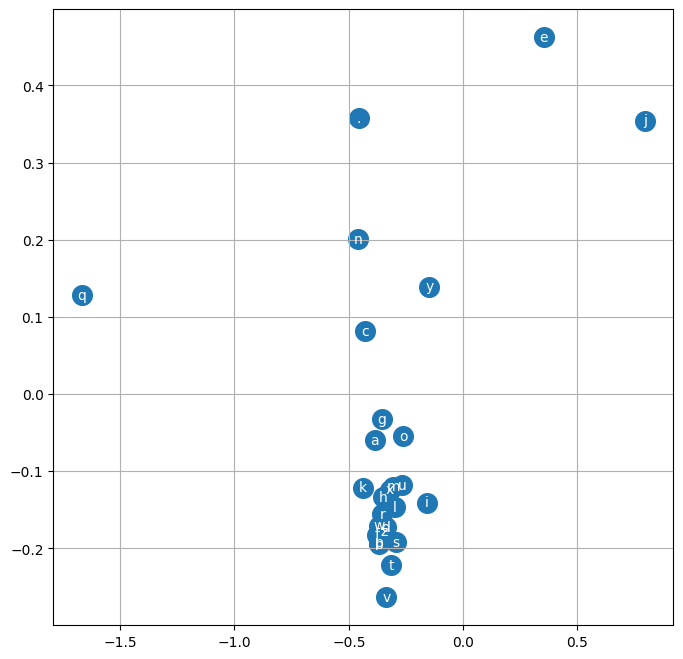

In [18]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [19]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [20]:
# sample from the model
g = torch.Generator().manual_seed(2525 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

salet.
ema.
audi.
arlher.
makel.
nayloona.
keizaeyzaglenne.
hamica.
drree.
gariah.
ida.
leil.
elyn.
airid.
quellyano.
yaanahir.
ari.
avar.
reen.
lilethaniha.
